# Convolutional Autoencoder, MNIST dataset


### Some comments:
- the 2 downconv + 2 upconv net is easier for training
- the 3+3 layers net I coded works well when trained on 20 epochs and a tanh layer as the last one of the decoder (why ReLU doesnt perform as well?)
- should try BCE loss

In [9]:
import os
import torch 
from torch.autograd import Variable
import torch.nn as nn
import torchvision
from torchvision import transforms 
from torchvision.utils import save_image
import random
from matplotlib import pyplot as plt

In [10]:
num_epochs = 20
batch_size = 100
learning_rate = 0.001
"""
sample_dir = '1st_autoencoder'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
"""    

"\nsample_dir = '1st_autoencoder'\nif not os.path.exists(sample_dir):\n    os.makedirs(sample_dir)\n"

In [11]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5))])

#dataset for training (download = True to download the dataset for the first time)
train_dataset = torchvision.datasets.MNIST('mnist/',train=True,transform=transform, download=False)
#loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#dataset for testing (download = True to download the dataset for the first time)
test_dataset = torchvision.datasets.MNIST('mnist/',train=False,transform=transform, download=False)
#loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Class definition

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc_1 = nn.Sequential(
            nn.Conv2d(1,16, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.enc_2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc_3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size = 3, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.dec_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2),
            nn.ReLU()
        )
        
        self.dec_2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 2),
            nn.ReLU()
        )       
        
        self.dec_3 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size = 8, stride = 2),
            nn.Tanh()
            #nn.ReLU()
        )        

    def forward(self, x):
        out = self.enc_1(x)
        out = self.enc_2(out)
        out = self.enc_3(out)
        
        out = self.dec_1(out)
        out = self.dec_2(out)
        out = self.dec_3(out)
        return out        

In [ ]:
# conv_autoencoder.py from github repo L1aoXingyu/pytorch-beginner :
"""
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
        nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
    )
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
        nn.Tanh()
    )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x   
"""

## Instantiation, training and saving the model

In [14]:
model = Autoencoder()
criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss() #instead of BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


#denormalize the image
def denorm(x):
    out = x*0.5 + 0.5
    return out.clamp(0, 1)

#train
model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        #backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        """ 
        if (i+1) % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        """        
        
torch.save(model.state_dict(), 'toy_autoencoder_tanh_mse.pkl')  

## Loading  a model and comparing results:

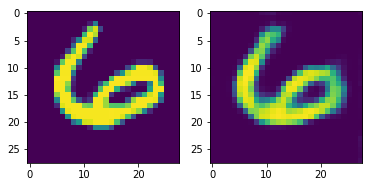

In [15]:
#loading
model_test = Autoencoder()
model_test.load_state_dict(torch.load('toy_autoencoder_tanh_mse.pkl'))

#autoencode a random image from the test dataset
model_test.eval()
test_image = random.choice(test_dataset)
test_reconst = model_test((test_image[0].unsqueeze_(0)))

#plotting (left = test_image ; right = test_reconst)
fig, axs = plt.subplots(1, 2)
axs[0].imshow( test_image[0][0][0])
axs[1].imshow( test_reconst[0][0].detach().numpy())
plt.show()
